In [56]:
using Revise
using Pkg; Pkg.activate("..")

using Dates
using Interpolations
using CSV
using DataFrames
using PyPlot

  Activating project at `~/Projects/submersible_humidity_sensor`


epoch name    | time
----          | ----
Zero C        |  15:16 to 15:22
Five C        |  15:50 to 15:56
Ten C         |  16:28 to 16:34
Fifteen C     |  17:03 to 17:09
Twenty C      |  17:39 to 17:45
Twenty Five C |  18:14 to 18:20
Thirty C      |  18:50 to 18:56
Thirty Five C |  20:50 to 20:56

In [55]:
# Jason's thermistor bridge standard
file_path = "../data/SHS/REC_001.txt"
df = CSV.read(file_path, DataFrame)
# println(df)

# RBR instrument, 2 T channels
rdf = CSV.read("../data/SHS/rsk_233860_20240523_1657.csv", DataFrame; comment="//")

Row,timestamp(yyyy-mm-ddTHH:MM:ss.FFF),temperature(°C),temperature1(°C)
,DateTime,Float64,Float64
1,2024-05-23T14:22:46,22.7707,22.7709
2,2024-05-23T14:22:46.500,22.7707,22.7709
3,2024-05-23T14:22:47,22.7707,22.7709
4,2024-05-23T14:22:47.500,22.772,22.773
5,2024-05-23T14:22:48,22.772,22.773
6,2024-05-23T14:22:48.500,22.772,22.773
7,2024-05-23T14:22:49,22.772,22.773
8,2024-05-23T14:22:49.500,22.7743,22.7751
9,2024-05-23T14:22:50,22.7743,22.7751


In [100]:
dt = DateTime.(df[!,"DATE TIME"], dateformat"yyyy-mm-dd HH:MM:SS")
dt_min = Dates.value.(Millisecond.(dt.-DateTime(2024,5,23)))./60_000

10248-element Vector{Float64}:
  915.65
  915.6833333333333
  915.7166666666667
  915.75
  915.7833333333333
  915.8166666666667
  915.85
  915.8833333333333
  915.9166666666666
  915.95
  915.9833333333333
  916.0166666666667
  916.05
    ⋮
 1256.85
 1256.8833333333334
 1256.9166666666667
 1256.95
 1256.9833333333333
 1257.0166666666667
 1257.05
 1257.0833333333333
 1257.1166666666666
 1257.15
 1257.1833333333334
 1257.2166666666667

In [101]:
# define time interpolators
dvm(dt) = Float64(Dates.value(Millisecond(dt-DateTime(2024,5,23))))

itpt(dt)  = interpolate(dvm.(rdf[!,"timestamp(yyyy-mm-ddTHH:MM:ss.FFF)"]), rdf[!,:temperature ], Gridded(Linear()))( dvm(dt) )
itpt1(dt) = interpolate(dvm.(rdf[!,"timestamp(yyyy-mm-ddTHH:MM:ss.FFF)"]), rdf[!,:temperature1], Gridded(Linear()))( dvm(dt) )
# bridge temperature
itptb(t)  = interpolate( (dvm.(dt),), df[!,:MEASUREMENT], Gridded(Linear()))( dvm(t) )
itptb(t::Vector)  = interpolate( (dvm.(dt),), df[!,:MEASUREMENT], Gridded(Linear()))( dvm.(t) )

itptb (generic function with 2 methods)

In [102]:
# interpolate bridge T to time of RBR
ii = unique(findall( dt[1] .<= rdf[!,"timestamp(yyyy-mm-ddTHH:MM:ss.FFF)"] .<= dt[end] ))
rdt = rdf[!,"timestamp(yyyy-mm-ddTHH:MM:ss.FFF)"][ii]
tb = itptb.( rdt )

40979-element Vector{Float64}:
  0.15101
  0.15100875000000002
  0.15100750000000002
  0.15100625
  0.151005
  0.151002
  0.150999
  0.150996
  0.150993
  0.15098725
  0.1509815
  0.15097575
  0.15097
  ⋮
 35.01877425
 35.018771
 35.0187705
 35.01877
 35.018769500000005
 35.018769
 35.0187705
 35.018772
 35.018773499999995
 35.018775
 35.0187745
 35.018774

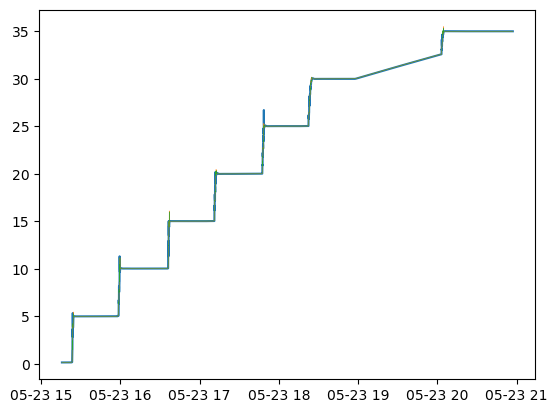

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x36a05a620>

In [112]:
clf()
plot(rdt, tb) # bridge interp to RBR
plot(rdt, rdf.var"    temperature(°C)"[ii], linewidth=0.3) # note sucky var name from CSV DataFrame
plot(rdt, rdf.var"    temperature1(°C)"[ii], linewidth=0.3)

break into stationary comparison chunks identified by Jason

In [ ]:
stidf = CSV.read("../data/SHS/start_intervals.txt", DataFrame) # start of 6 min intervals
stidt = @. DateTime(2024,5,23,stidf[!,:hour], stidf[!,:minute])

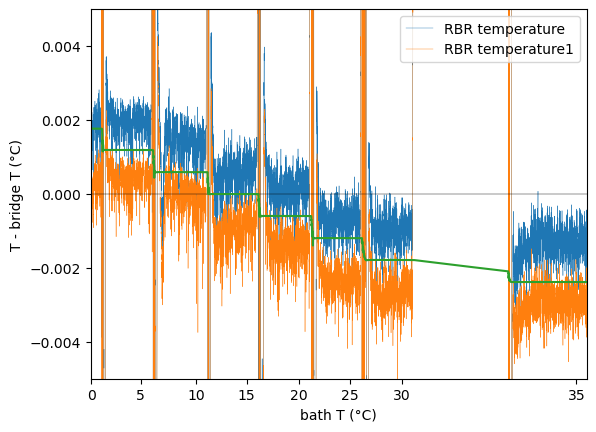

PyObject Text(0.5, 24.0, 'bath T (°C)')

In [135]:
clf()
# plot(rdt, tb) # bridge interp to RBR
plot(rdt, rdf.var"    temperature(°C)"[ii].-tb, linewidth=0.3, label="RBR temperature") # note sucky var name from CSV DataFrame
plot(rdt, rdf.var"    temperature1(°C)"[ii].-tb, linewidth=0.3, label="RBR temperature1")
plot(rdt[[1, end]], [0, 0], color="k", linewidth=0.3)
plot(rdt, -(tb.-15)./8400)
ylim([-0.005, 0.005])
xlim(rdt[[1, end]])
xticks(stidt, 0:5:35)
legend()
ylabel("T - bridge T (°C)")
xlabel("bath T (°C)")

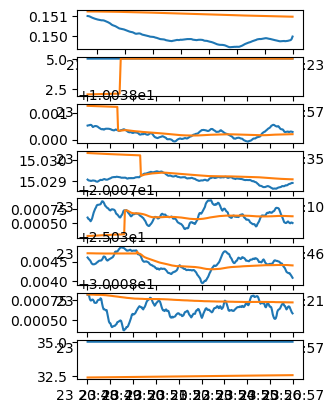

In [52]:
for (i, sdt) in enumerate( stidt )
    subplot(8,2,2*i-1)
    ii = (sdt - Minute(2) .<= dt .<= sdt + Minute(7))
    plot(dt[ii], df[!,:MEASUREMENT][ii])
    plot(dt[ii], df[!,:MEAN][ii])
    # xlim(sdt .+ Minute.([0, 6]))
end
# huh?

In [ ]:
CSV.read